In [1]:
import os
import shared.data_utils as data_utils
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import modules
#import modules2 as modules
import time
from contextlib import nullcontext

In [2]:
torch.compiler.reset()
torch._dynamo.reset()

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
device_type = 'cuda'
device = torch.device(device_type)
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.autocast(device_type=device_type, dtype=ptdtype)

In [4]:
random_seed = 123
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
batch_size = 4
shuffle = False
#device = torch.device("cpu")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare synthetic dataset

/tmp/ipykernel_7584/2150453358.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  {'vertices': data_utils.dequantize_verts(torch.tensor(shape['vertices'])),
/tmp/ipykernel_7584/2150453358.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'faces': data_utils.unflatten_faces(torch.tensor(shape['faces']))})


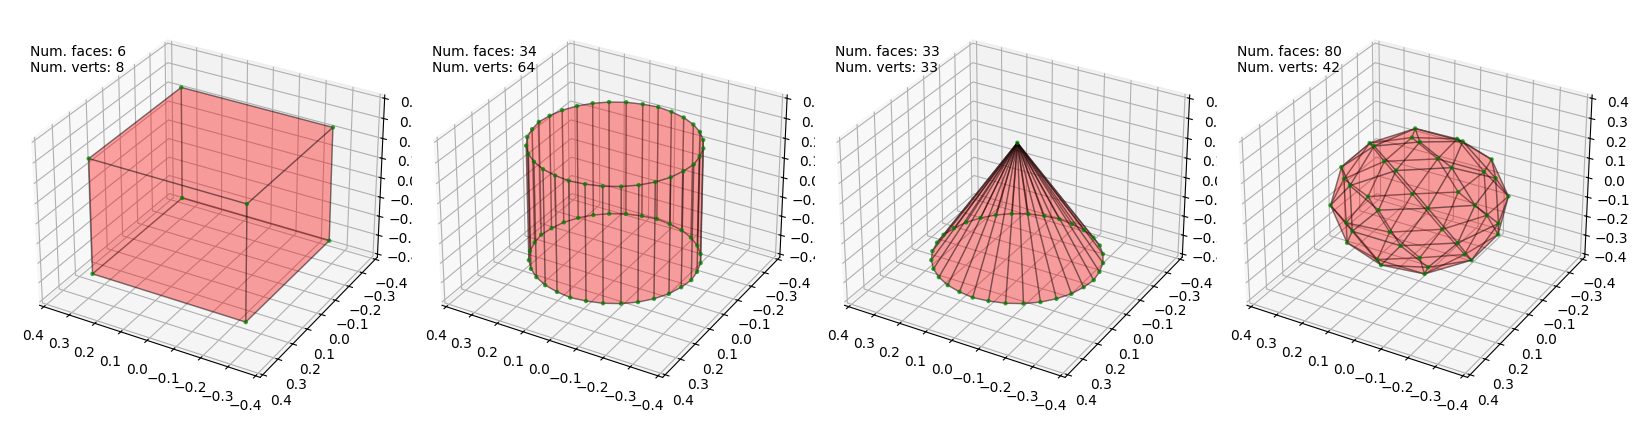

In [5]:
class MeshDataset(Dataset):
    def __init__(self, mesh_list):
        self.mesh_list = mesh_list 

    def __len__(self):
        return len(self.mesh_list)

    def __getitem__(self, idx):
        return self.mesh_list[idx]
    
    def map(self, func):
        for i in range(len(self.mesh_list)):
           self.mesh_list[i] = func(self.mesh_list[i])
        return self

# Prepare synthetic dataset
ex_list = []
for k, mesh in enumerate(['cube', 'cylinder', 'cone', 'icosphere']):
    mesh_dict = data_utils.load_process_mesh(
        os.path.join('meshes', '{}.obj'.format(mesh)))
    mesh_dict['class_label'] = torch.tensor(k)
    mesh_dict['vertices'] = torch.tensor(mesh_dict['vertices'])
    mesh_dict['faces'] = torch.tensor(mesh_dict['faces'])
    ex_list.append(mesh_dict)

synthetic_dataset = MeshDataset(ex_list)

# Plot the meshes
mesh_list = []

for shape in synthetic_dataset:
    mesh_list.append(
      {'vertices': data_utils.dequantize_verts(torch.tensor(shape['vertices'])),
        'faces': data_utils.unflatten_faces(torch.tensor(shape['faces']))})
data_utils.plot_meshes(mesh_list, ax_lims=0.4)

## Create vertex model

In [6]:
# Prepare the dataset for vertex model training
def pad_batch(batch):
    # group matching keys in batch
    items = list(zip(*[item.values() for item in batch]))
    packed_dict = {}
    for i, key in enumerate(batch[0].keys()):
        if items[i][0].dim() == 0:
            padded_values = torch.tensor(items[i], device=device)
        else:
            padded_values = torch.nn.utils.rnn.pad_sequence(items[i], batch_first=True, padding_value=0.).to(device)
        packed_dict[key] = padded_values
    return packed_dict

vertex_model_dataset = data_utils.make_vertex_model_dataset(
    synthetic_dataset, apply_random_shift=False)



vertex_model_dataloader = iter(DataLoader(vertex_model_dataset, 
                                          shuffle=shuffle, 
                                          batch_size=batch_size, 
                                          collate_fn=pad_batch))
vertex_model_batch = next(vertex_model_dataloader)

max_num_input_verts=250

decoder_config={
        'embd_size': 128,
        'fc_size': 512, 
        'num_layers': 3,
        'dropout_rate': 0.,
        'take_context_embedding': False
}

# Create vertex model
vertex_model = modules.VertexModel(
    decoder_config=decoder_config,
    class_conditional=True,
    context_type='label',
    num_classes=4,
    max_num_input_verts=max_num_input_verts,
    quantization_bits=8,
    device=device
).to(device=device)
#vertex_model = torch.compile(vertex_model) #,mode="reduce-overhead"

with ctx:
    vertex_model_pred_dist = vertex_model(vertex_model_batch)

vertex_model_loss = -torch.sum(
    vertex_model_pred_dist.log_prob(vertex_model_batch['vertices_flat']) * 
    vertex_model_batch['vertices_flat_mask'])

with ctx:
    vertex_samples = vertex_model.sample(
    4, context=vertex_model_batch, max_sample_length=max_num_input_verts, top_p=0.95,
    recenter_verts=False, only_return_complete=False)

print(vertex_model_batch)
print(vertex_model_pred_dist)
print(vertex_samples)

{'vertices': tensor([[[ 53,  53,  53],
         [201,  53,  53],
         [ 53, 201,  53],
         [201, 201,  53],
         [ 53,  53, 201],
         [201,  53, 201],
         [ 53, 201, 201],
         [201, 201, 201],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],

## Create face model

In [7]:
face_model_dataset = data_utils.make_face_model_dataset(
    synthetic_dataset, apply_random_shift=False)

face_model_dataloader = iter(DataLoader(face_model_dataset, 
                                        shuffle=shuffle, 
                                        batch_size=batch_size,
                                        collate_fn=pad_batch))
face_model_batch = next(face_model_dataloader)

encoder_config={
        'embd_size': 128,
        'fc_size': 512, 
        'num_layers': 3,
        'num_heads': 4,
        'dropout_rate': 0.
}
decoder_config={
    'embd_size': 128,
    'fc_size': 512, 
    'num_layers': 3,
    'dropout_rate': 0.,
    'num_heads': 4,
    'take_context_embedding': True
}

# Create face model
face_model = modules.FaceModel(
    encoder_config=encoder_config,
    decoder_config=decoder_config,
    class_conditional=False,
    max_seq_length=500,
    quantization_bits=8,
    max_num_input_verts=max_num_input_verts,
    decoder_cross_attention=True,
    use_discrete_vertex_embeddings=True,
    device=device
).to(device=device)
#face_model = torch.compile(face_model) #,mode="reduce-overhead"

with ctx:
    face_model_pred_dist = face_model(face_model_batch)
face_model_loss = -torch.sum(face_model_pred_dist.log_prob(face_model_batch['faces']) * 
    face_model_batch['faces_mask'])

with ctx:
    face_samples = face_model.sample(
    context=vertex_samples, max_sample_length=500, top_p=0.95,
    only_return_complete=False)
print(face_model_batch)
print(face_model_pred_dist)
print(face_samples)

/home/charlie/Documents/polygen/shared/data_utils.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vertices = torch.tensor(example['vertices'])


{'vertices': tensor([[[-0.2922, -0.2922,  0.2882],
         [ 0.2882, -0.2922,  0.2882],
         [ 0.2882, -0.2922, -0.2922],
         [ 0.2882,  0.2882,  0.2882],
         [-0.2922,  0.2882,  0.2882],
         [ 0.2882,  0.2882, -0.2922],
         [-0.2922, -0.2922, -0.2922],
         [-0.2922,  0.2882, -0.2922],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],

## Train models

Step 0
Loss (vertices) 2573.20458984375
Loss (faces) 2852.82666015625
Time (ms): 177.89292335510254


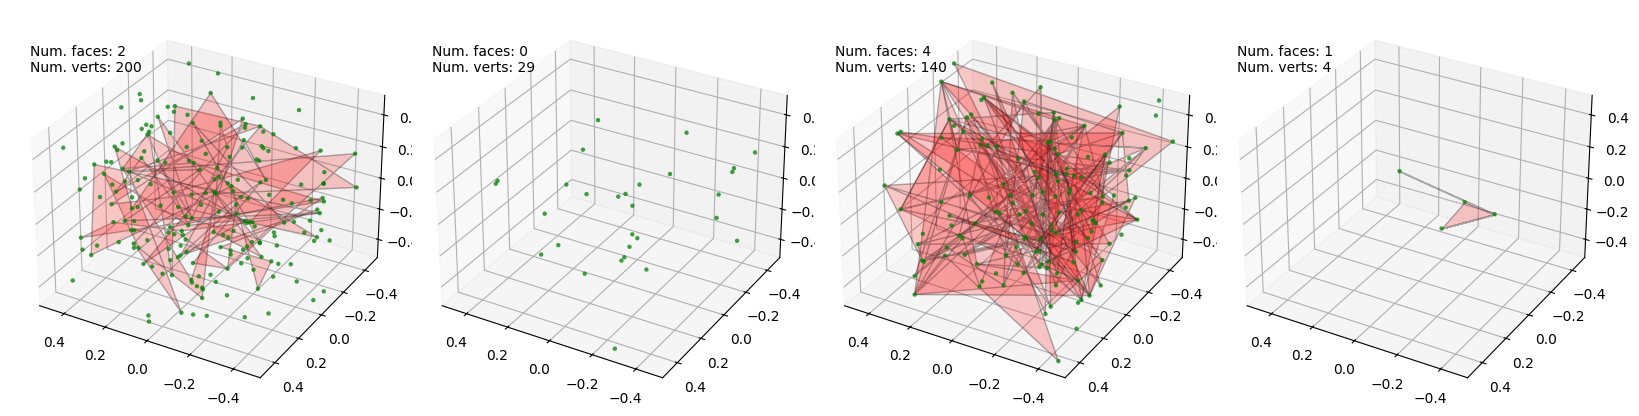

Step 5
Loss (vertices) 2406.25439453125
Loss (faces) 2647.5859375
Time (ms): 37.39476203918457
Step 10
Loss (vertices) 2239.1572265625
Loss (faces) 2476.137451171875
Time (ms): 51.499366760253906
Step 15
Loss (vertices) 2063.919921875
Loss (faces) 2338.597900390625
Time (ms): 38.18178176879883
Step 20
Loss (vertices) 1848.33740234375
Loss (faces) 2197.630126953125
Time (ms): 46.93889617919922
Step 25
Loss (vertices) 1585.0887451171875
Loss (faces) 2070.10546875
Time (ms): 37.7652645111084


In [8]:
# Optimization settings
learning_rate = 8e-4 #3e-4
training_steps = 300
log_step = 5
sample_step = 25
n_samples = 4

# Create an optimizer an minimize the summed log probability of the mesh sequences
face_model_optim = torch.optim.AdamW(face_model.parameters(), lr=learning_rate)
vertex_model_optim = torch.optim.AdamW(vertex_model.parameters(), lr=learning_rate)

vertex_model_dataloader = DataLoader(vertex_model_dataset, 
                                     shuffle=shuffle, 
                                     batch_size=batch_size, 
                                     collate_fn=pad_batch)
face_model_dataloader = DataLoader(face_model_dataset, 
                                   shuffle=shuffle, 
                                   batch_size=batch_size, 
                                   collate_fn=pad_batch)
vertex_model_dataloader_iter = iter(vertex_model_dataloader)
face_model_dataloader_iter = iter(face_model_dataloader)

#print("V", next(vertex_model_dataloader_iter))
#print("F", next(face_model_dataloader_iter))

# Training loop
for n in range(training_steps):
    try:
      vertex_model_batch = next(vertex_model_dataloader_iter)
    except StopIteration:
      vertex_model_dataloader_iter = iter(vertex_model_dataloader)
      vertex_model_batch = next(vertex_model_dataloader_iter)

    try:
      face_model_batch = next(face_model_dataloader_iter)
    except StopIteration:
      face_model_dataloader_iter = iter(face_model_dataloader)
      face_model_batch = next(face_model_dataloader_iter)
    
    t = time.time()

    with ctx:
      vertex_model_pred_dist = vertex_model(vertex_model_batch)
      
      
      face_model_pred_dist = face_model(face_model_batch)
      
      
    vertex_model_loss = -torch.sum(
        vertex_model_pred_dist.log_prob(vertex_model_batch['vertices_flat']) * 
        vertex_model_batch['vertices_flat_mask'])  
    
    face_model_loss = -torch.sum(face_model_pred_dist.log_prob(face_model_batch['faces']) * 
        face_model_batch['faces_mask'])
    
    # Run the optimization step after sample so it uses the old parameters
    vertex_model_optim.zero_grad()
    vertex_model_loss.backward()
    torch.nn.utils.clip_grad_norm_(vertex_model.parameters(), 1.0)
    vertex_model_optim.step()

    face_model_optim.zero_grad()
    face_model_loss.backward()
    torch.nn.utils.clip_grad_norm_(face_model.parameters(), 1.0)
    face_model_optim.step()

    # time forward pass
    dt = time.time() - t
    if n % log_step == 0:
        print('Step {}'.format(n))
        print('Loss (vertices) {}'.format(vertex_model_loss))
        print('Loss (faces) {}'.format(face_model_loss)) 
        print('Time (ms): {}'.format(dt * 1000))

        if n % sample_step == 0:
          with ctx:
            vertex_samples = vertex_model.sample(
              n_samples, context=vertex_model_batch, max_sample_length=200, top_p=0.95,
              recenter_verts=False, only_return_complete=False)
            
            face_samples = face_model.sample(
              context=vertex_samples, max_sample_length=500, top_p=0.95,
              only_return_complete=False)
          
          """ vertex_samples = vertex_model.to(device='cpu').sample(
          n_samples, context=vertex_model_batch, max_sample_length=200, top_p=0.95,
          recenter_verts=False, only_return_complete=False)

          face_samples = face_model.to(device='cpu').sample(
          context=vertex_samples, max_sample_length=500, top_p=0.95,
          only_return_complete=False) """
          
          mesh_list = []
          for n in range(min(n_samples, batch_size)):
              mesh_list.append(
                {
                  'vertices': vertex_samples['vertices'][n][:vertex_samples['num_vertices'][n]].cpu(),
                  'faces': data_utils.unflatten_faces(
                    face_samples['faces'][n][:face_samples['num_face_indices'][n]].cpu())
                }
              )
          try:
            # sometimes theres an error when training on cpu... not sure why
            data_utils.plot_meshes(mesh_list, ax_lims=0.5)
          except:
            print("Error plotting meshes... skipping.")
          #vertex_model.to(device=device)
          #face_model.to(device=device)

#print(vertex_model.state_dict() == vertex_model.to('cpu').state_dict())

## Inference

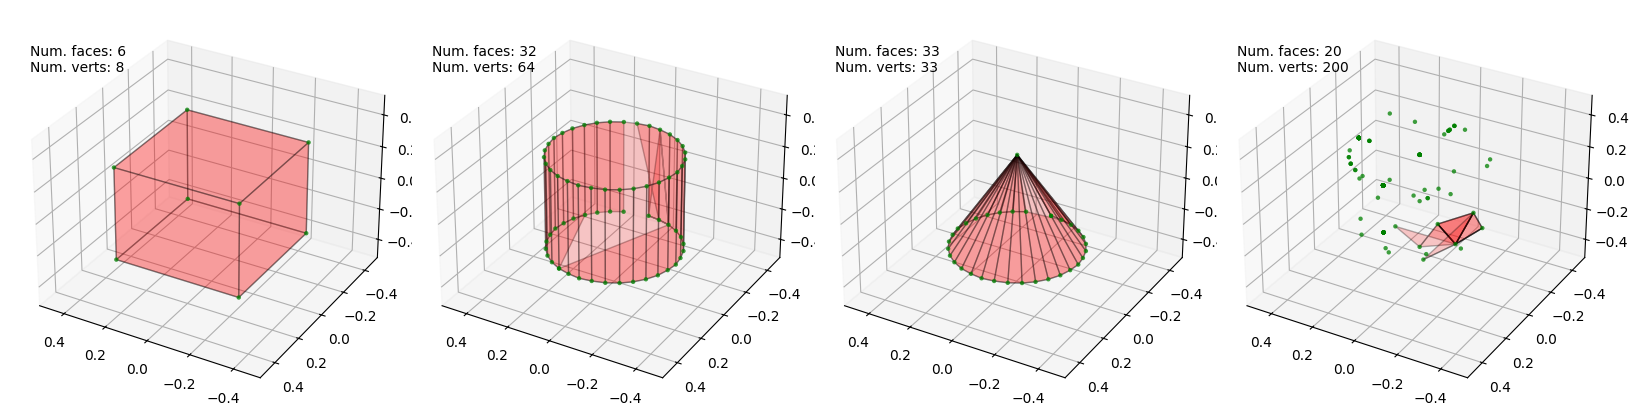

In [ ]:
#import importlib
#importlib.reload(data_utils)

vertex_model_dataloader = DataLoader(vertex_model_dataset, shuffle=shuffle, batch_size=batch_size, collate_fn=pad_batch)
vertex_model_dataloader_iter = iter(vertex_model_dataloader)
vertex_model_batch = next(vertex_model_dataloader_iter)

for key, value in vertex_model_batch.items():
    #vertex_model_batch[key] = value.to('cpu')
    vertex_model_batch[key] = value.to('cuda')

vertex_samples = vertex_model.to('cuda').sample(
    n_samples, context=vertex_model_batch, max_sample_length=200, top_p=0.95,
    recenter_verts=False, only_return_complete=False)    

face_samples = face_model.to('cuda').sample(
    context=vertex_samples, max_sample_length=500, top_p=0.95,
    only_return_complete=False)

""" vertex_samples = vertex_model.to(device='cpu').sample(
    n_samples, context=vertex_model_batch, max_sample_length=200, top_p=0.95,
    recenter_verts=False, only_return_complete=False)    

face_samples = face_model.to(device='cpu').sample(
    context=vertex_samples, max_sample_length=500, top_p=0.95,
    only_return_complete=False)  """

mesh_list = []
for n in range(min(n_samples, batch_size)):
    mesh_list.append(
    {
        'vertices': vertex_samples['vertices'][n][:vertex_samples['num_vertices'][n]].to('cpu'),
        'faces': data_utils.unflatten_faces(
        face_samples['faces'][n][:face_samples['num_face_indices'][n]].to('cpu'))
    }
    )
    
data_utils.plot_meshes(mesh_list, ax_lims=0.5)

In [ ]:
import torch

torch._dynamo.list_backends()

['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'openxla_eval', 'tvm']

In [ ]:
torch.onnx.is_onnxrt_backend_supported()

False

In [ ]:
from flash_attn import flash_attn_qkvpacked_func, flash_attn_func, flash_attn_varlen_func

device = torch.device('cuda')
b = 4
query_seq_len = 4
n_head = 2
n_embd = 8
kv_seq_len = 2

q_mask = torch.tensor([[0,0,1,1],[0,1,1,1],[0,0,0,0],[0,0,0,1]], device=device)
k_mask = torch.tensor([[0,0,1,1],[0,1,1,1],[0,0,0,0],[0,0,0,1]], device=device)

# q = torch.rand((b, query_seq_len, n_head, n_embd // n_head)).transpose(1, 2)
# k = torch.rand((b, query_seq_len, n_head, n_embd // n_head)).transpose(1, 2)
# v = torch.rand((b, query_seq_len, n_head, n_embd // n_head)).transpose(1, 2)
q = torch.rand((b, query_seq_len, n_head, n_embd // n_head), device=device).half()
k = torch.rand((b, kv_seq_len, n_head, n_embd // n_head), device=device).half()
v = torch.rand((b, kv_seq_len, n_head, n_embd // n_head), device=device).half()

#print((q_mask == 0).sum(), (q_mask == 0).sum(-1).max())
#print((q_mask == 0).float().sum(dim=-1), q_mask == 0)
with ctx:
    cu_seqlens_q = (q_mask == 0).sum().int()
    cu_seqlens_k = (k_mask == 0).sum().int()
    max_seqlen_q = (q_mask == 0).sum(-1).max()
    max_seqlen_k= (k_mask == 0).sum(-1).max()

    #result = torch.tensor([], dtype=batch.dtype)
    q_result = torch.tensor([], dtype=batch.dtype)
    k_result = torch.tensor([], dtype=batch.dtype)
    v_result = torch.tensor([], dtype=batch.dtype)
    # Process each sequence
    for seq in batch:
        # Find the index of the first non-zero element after the first zero
        # We will use this index to slice the sequence, keeping up to the first zero
        zeros = (seq == 0).nonzero(as_tuple=True)[0]
        if len(zeros) > 0:
            first_zero_index = zeros[0].item() + 1  # Include the first zero
            seq_slice = seq[:first_zero_index]  # Slice the sequence
        else:
            seq_slice = seq  # Keep the whole sequence if no zero is found
        
        # Concatenate to the result tensor
        result = torch.cat((result, seq_slice), dim=0)

    # Result is a 1D tensor, but we can add an extra dimension to make it 1xN if needed
    result = result.unsqueeze(0)

    q = q.view((b*query_seq_len, n_head, n_embd // n_head))
    k = k.view((b*kv_seq_len, n_head, n_embd // n_head))
    v = v.view((b*kv_seq_len, n_head, n_embd // n_head))
    # q: (total_q, nheads, headdim), where total_q = total number of query tokens in the batch.
    # k: (total_k, nheads_k, headdim), where total_k = total number of key tokens in the batch.
    # v: (total_k, nheads_k, headdim), where total_k = total number of key tokens in the batch.
    # cu_seqlens_q: (batch_size + 1,), dtype torch.int32. The cumulative sequence lengths
    #    of the sequences in the batch, used to index into q.
    # cu_seqlens_k: (batch_size + 1,), dtype torch.int32. The cumulative sequence lengths
    #    of the sequences in the batch, used to index into kv.
    # max_seqlen_q: int. Maximum query sequence length in the batch.
    # max_seqlen_k: int. Maximum key sequence length in the batch.

    print("P", torch.cumsum(torch.tensor([2,4,6,8]), dim=0))

    print(q.shape, k.shape, v.shape)
    print(cu_seqlens_q.shape, max_seqlen_q.shape)

    print("X", max_seqlen_q.item())
    print(cu_seqlens_q)

    #cu_seqlens_q = torch.tensor(b+1, dtype=torch.int32, device=device).unsqueeze(0)
    #cu_seqlens_k = torch.tensor(b+1, dtype=torch.int32, device=device).unsqueeze(0)
    print((q_mask == 0).sum(-1))
    cu_seqlens_q = torch.cumsum((q_mask == 0).sum(-1), dim=0, dtype=torch.int32)
    cu_seqlens_k = torch.cumsum((k_mask == 0).sum(-1), dim=0, dtype=torch.int32)
    print("Z", cu_seqlens_q)
    flash_attn_varlen_func(
    q,
    k,
    v,
    cu_seqlens_q,
    cu_seqlens_k,
    max_seqlen_q.item(),
    max_seqlen_k.item())

    #(batch_size, seqlen, 3, nheads, headdim
    #flash_attn_func(q,k,v, dropout_p=0.0, softmax_scale=None, causal=False)

    #qkv = torch.stack([q,k,v], dim=2).half()
    #flash_attn_qkvpacked_func(qkv, dropout_p=0.0, softmax_scale=None, causal=False)

NameError: name 'batch' is not defined